# Example Applications of Mixture of Factor Analyzers Model

* 4D to 3D with complete data
* 4D to 2D with complete data
* 4D to 2D with missing data
* Model selection via BIC/ICL

The examples below illustrate how the clustering performs on simulated data,
first in the complete case and afterwards with missing data. Model selection
and training are shown as well. For the simulated data, we draw 200 points from
three-component 4D-Gaussian distributions each.

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')  # ensure consistent plots
import numpy as np

from mcfa import MCFA

## Simulate Gaussian data

We simulate a three-component Gaussian distribution in four dimensions.

In [2]:
p = 4 # number of data dimensions
N = 200  # number of random samples drawn

# Define the means and covariances of the three Gaussians components
seed = 7  # set seed for reproducibility
np.random.seed(seed)
mu1 = np.random.rand(p) * 5  # * 5 to scale the data, random.rand -> [0, 1)
cov1 = np.random.rand(p, p)
cov1 = np.dot(cov1, cov1.T)  # For any matrix A, A*A is positive semidefinite

seed = 17
np.random.seed(seed)
mu2 = np.random.rand(p) * 5
cov2 = np.random.rand(p, p)
cov2 = np.dot(cov2, cov2.T)

seed = 4
np.random.seed(seed)
mu3 = np.random.rand(p) * 5
cov3 = np.random.rand(p, p)
cov3 = np.dot(cov3, cov3.T)

# Sample N points from the distributions
cluster1 = np.random.multivariate_normal(mu1, cov1, size=N)
cluster2 = np.random.multivariate_normal(mu2, cov2, size=N)
cluster3 = np.random.multivariate_normal(mu3, cov3, size=N)

data = np.concatenate([cluster1, cluster2, cluster3], axis=0)

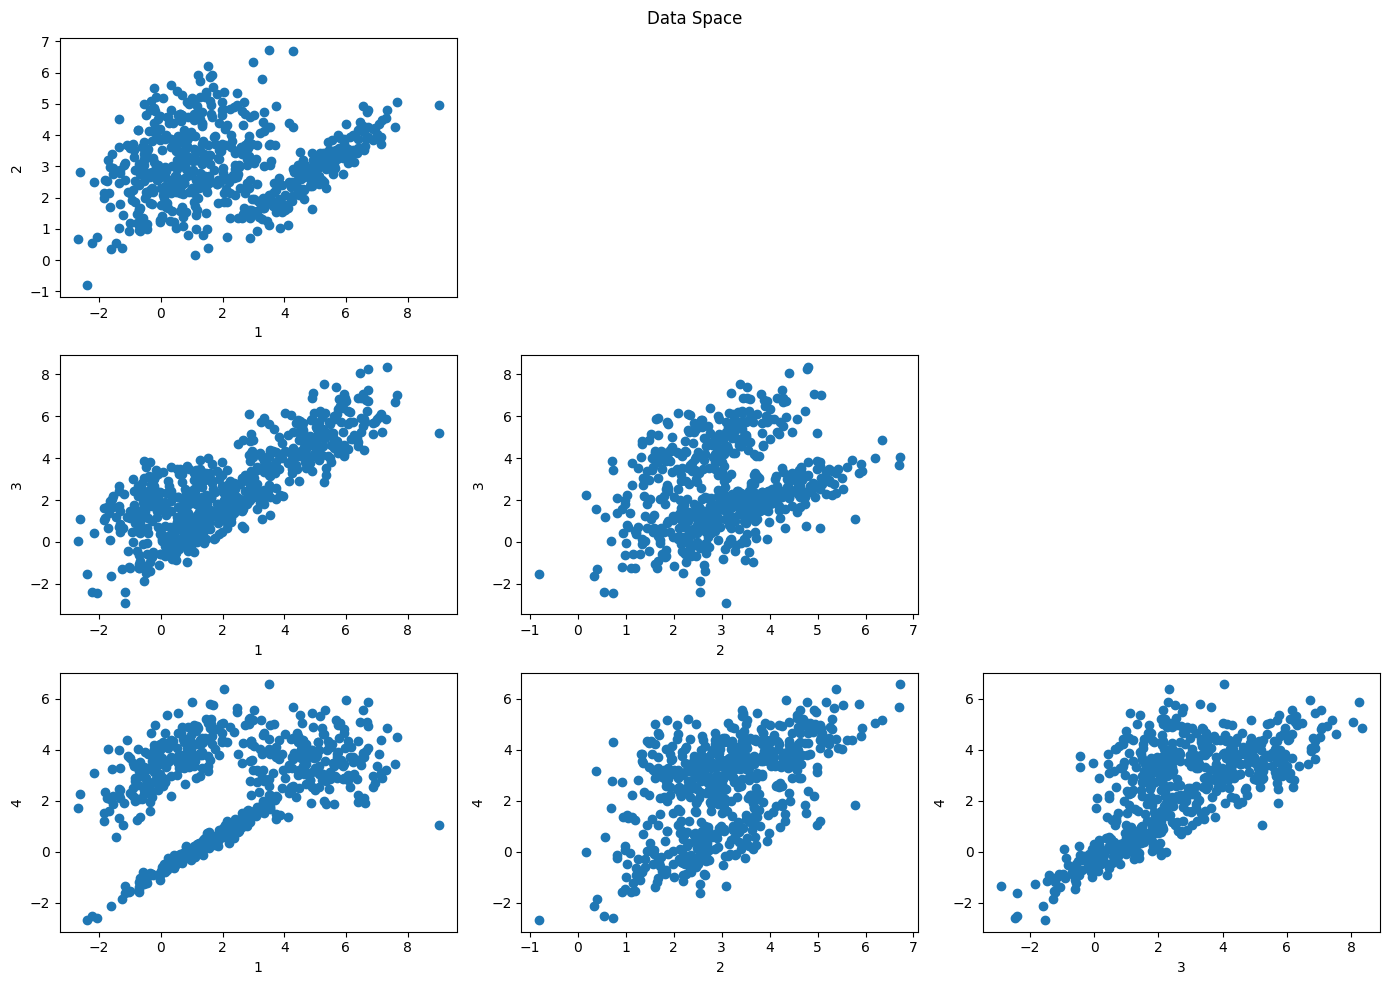

In [3]:
# Create triangular figure of 2d projections of dimension pairs
fig, axes = plt.subplots(ncols=p - 1, nrows=p - 1, figsize=(14, 10))

for i in range(p - 1):
    for j in range(p - 1):

        ax = axes[i, j]
        px = j  # index of data feature to plot on x-axis
        py = i + 1  # index of data feature to plot on y-axis

        if px >= py:
            ax.axis("off")
            continue

        ax.scatter(data[:, px], data[:, py])
        ax.set(xlabel=f"{px + 1}", ylabel=f"{py + 1}")

fig.suptitle("Data Space")
plt.tight_layout()

We now instantiate the MCFA model and fit the model components to the data. The 600 4D observations are clustered in 3D-space (`n_factors=3`) using 3 components (`n_components=3`).

In [4]:
g = 3  # number of latent components
q = 3  # number of latent factors

# Instantiate model
model = MCFA(n_components=g, n_factors=q)

# Fit the model parameters using ML
model.fit(
    data,
    n_epochs=300,  # number of training epochs
    learning_rate=1e-4,  # learning rate of gradient descent algorithm
    frac_validation=0.15,  # fraction of data used as validation set during training
    batch_size=4,  # batch size during gradient descent training
);

Training :   0%|          | 0/300 [00:00<?, ?epoch/s]

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Training : 100%|██████████| 300/300 [01:38<00:00,  3.04epoch/s]


We can evaluate the convergence of the model parameters using the log-likelihood curves of the training and the validation set. Choose a number of epochs at which the loss curve is converging towards a constant value. Further training results in overfitting of the model parameters to the training data.

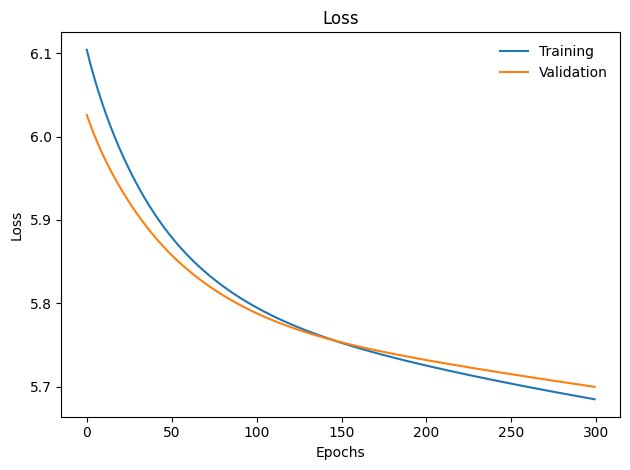

In [5]:
model.plot_loss()

During the training, the model parameters were set. We can now project any data with the same features into the latent space, achieving the dimensionality reduction (note the reduction in the second dimension of the data shape). We do this here for the training data.

In [6]:
Z = model.transform(data)
print(f"Shape of original data: {data.shape}, shape of transformed data: {Z.shape}")

Shape of original data: (600, 4), shape of transformed data: (600, 3)


Next, we compute for each sample the probability to belong to either of the three components, referred to as responsibility matrix. We then compute the final cluster assignment (the most likely component) for each sample.

In [7]:
clusters = model.predict(data)
responsibility = model.predict_proba(data)

print("Number of samples per cluster:") # should be close to 200:200:200
print(Counter(clusters))

sample = 89  # A random sample just to show how to access the results

for cluster in range(g):
    print(f"Sample {sample} has a {responsibility[sample-1 , cluster] * 100:.2f}% probability to belong to cluster {cluster}.")
print(f"It was assigned to cluster {clusters[0]}.")


Number of samples per cluster:
Counter({2: 201, 0: 200, 1: 199})
Sample 89 has a 100.00% probability to belong to cluster 0.
Sample 89 has a 0.00% probability to belong to cluster 1.
Sample 89 has a 0.00% probability to belong to cluster 2.
It was assigned to cluster 0.


Now, we plot the data in the reduced, three-dimensional space using the latent scores $Z$.

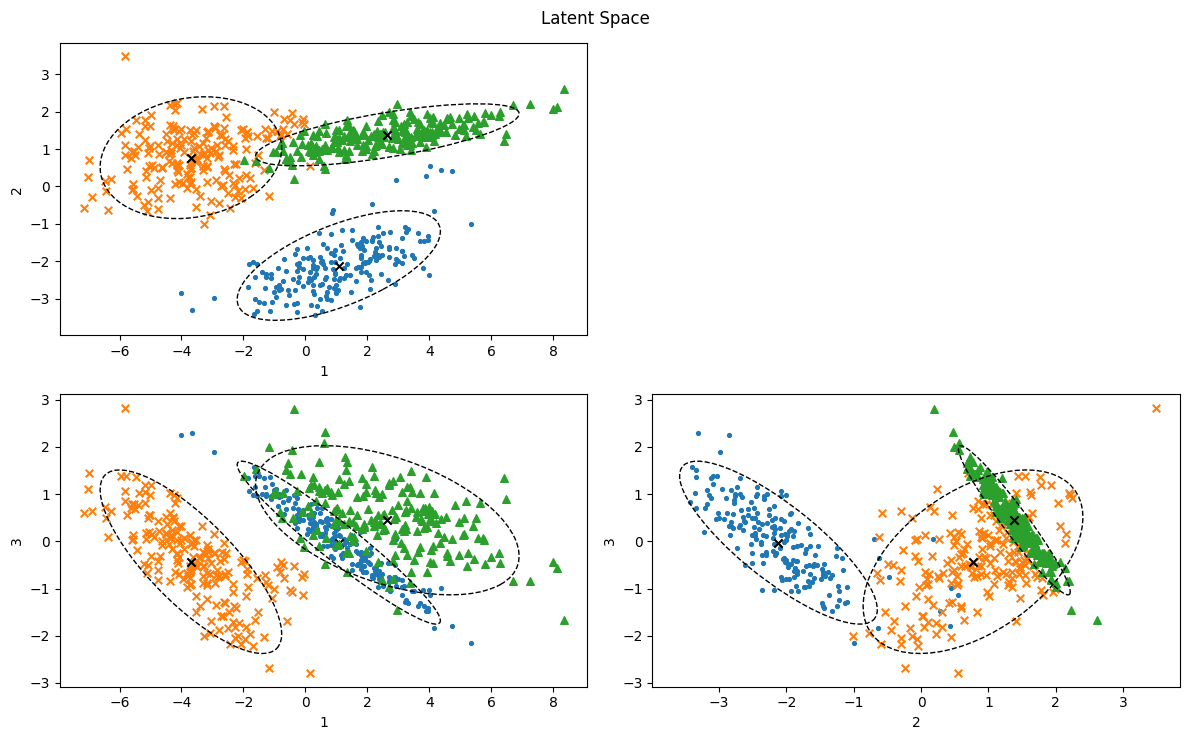

In [8]:
model.plot_latent_space(Z=Z, clusters=clusters)

And this is the original data, color-coded by the cluster assigned by the model, and the cluster distributions in data space (mean and standard deviation).

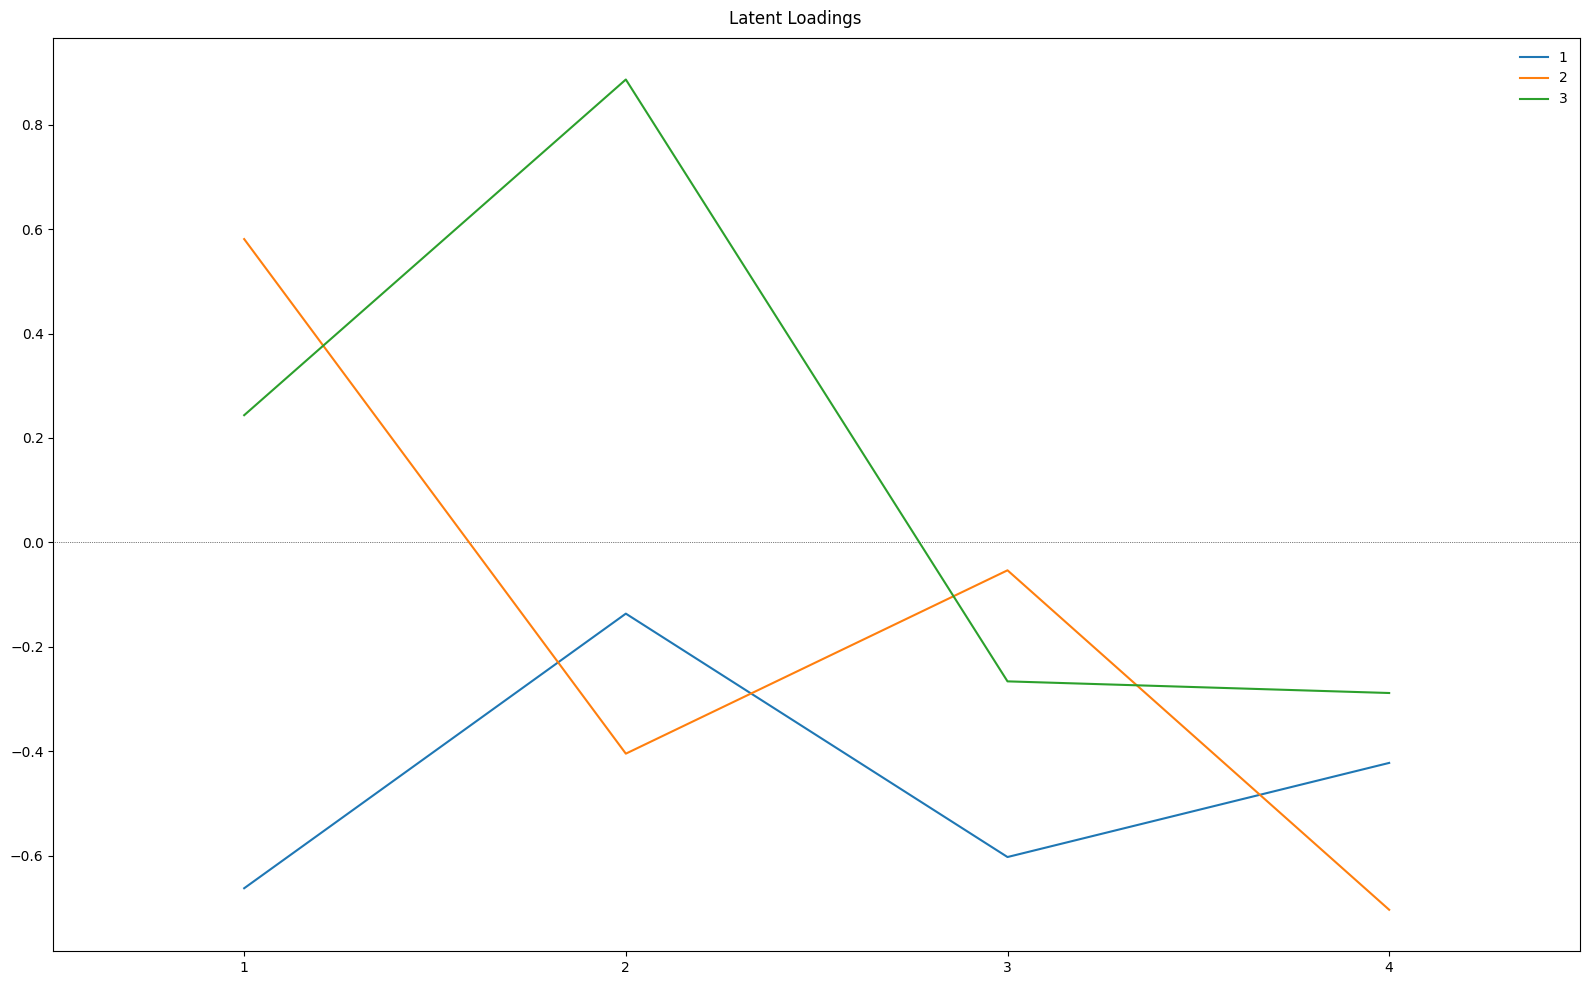

In [9]:
model.plot_latent_loadings()

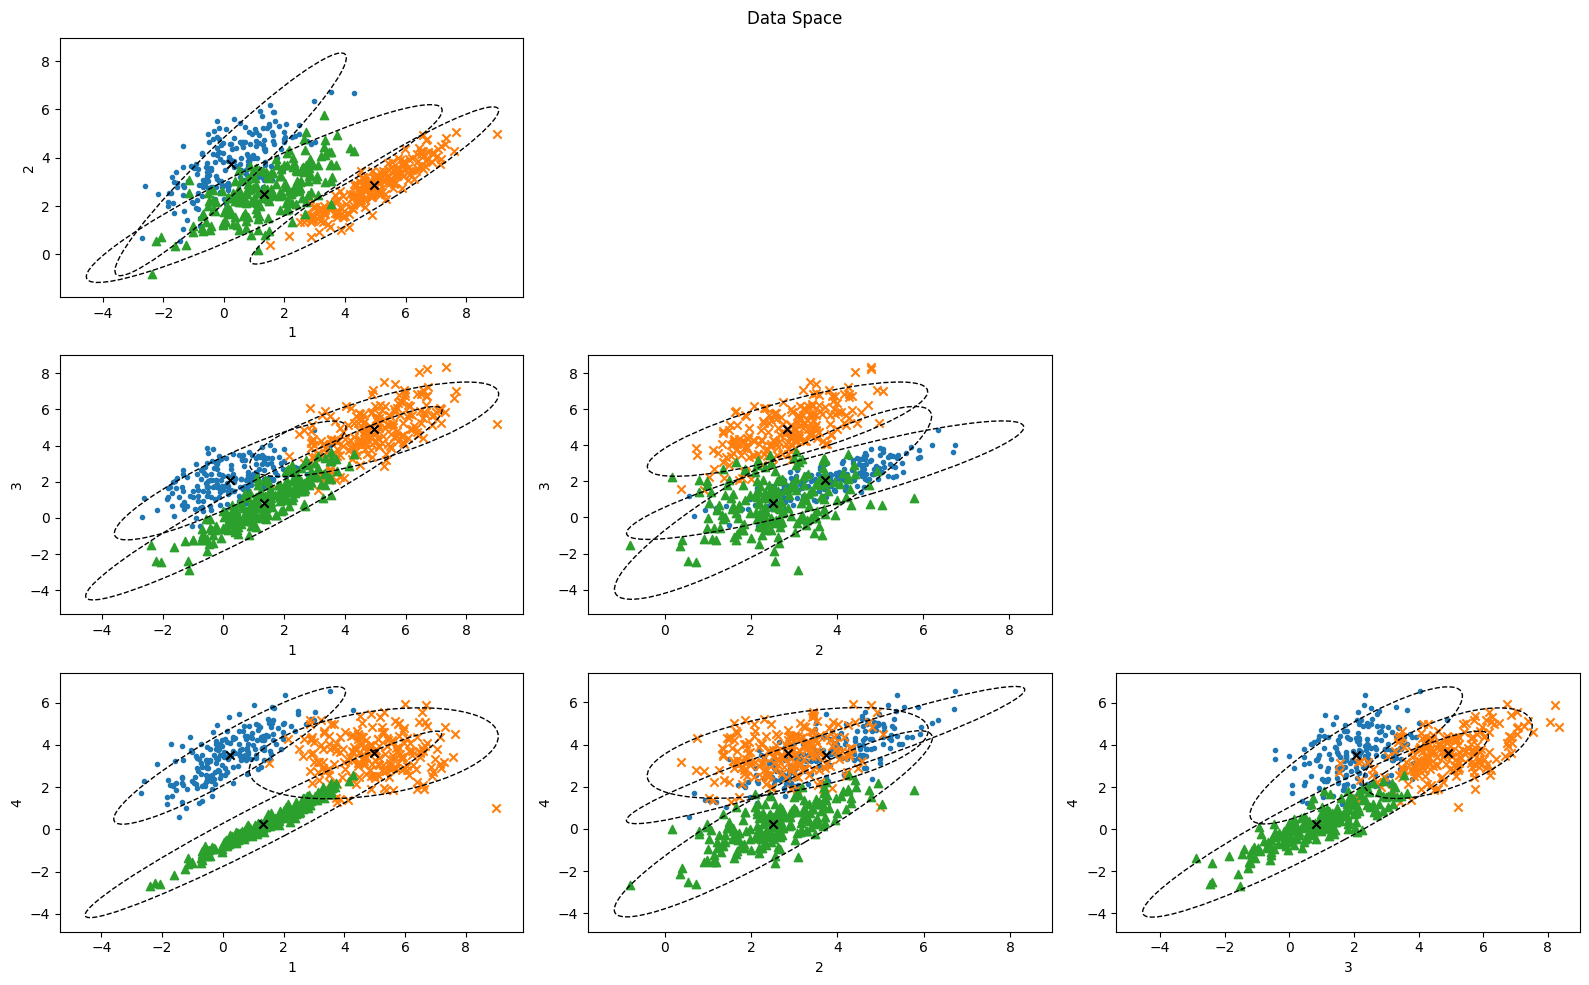

In [10]:
model.plot_data_space(Y=data, clusters=clusters)

## 4D-Gaussian distribution in 2D-latent space

We repeat the exercise above while reducing the dimensionality from 4D to 2D.

In [11]:
g = 3  # number of latent components
q = 2  # number of latent factors

# Instantiate model
model = MCFA(n_components=g, n_factors=q)

# Fit the model parameters using ML
model.fit(
    data,
    n_epochs=300,  # number of training epochs
    learning_rate=1e-4,  # learning rate of gradient descent algorithm
    frac_validation=0.15,  # fraction of data used as validation set during training
    batch_size=4,  # batch size during gradient descent training
);

Training : 100%|██████████| 300/300 [01:38<00:00,  3.06epoch/s]


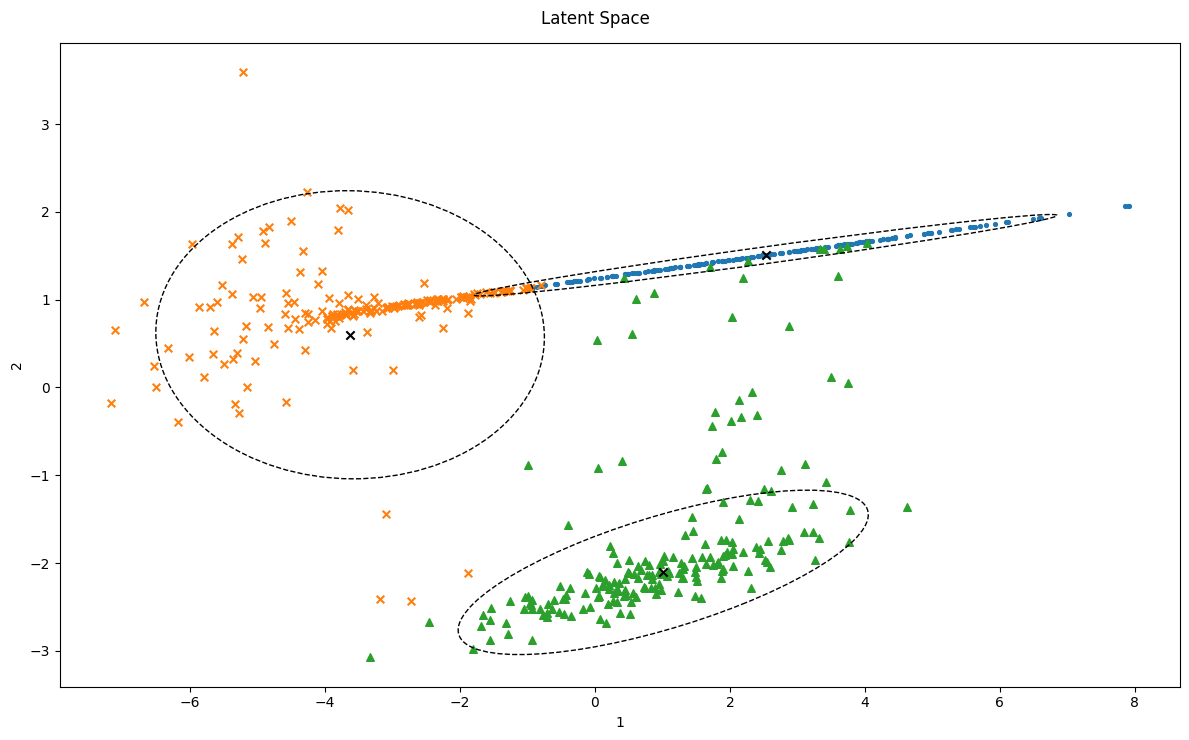

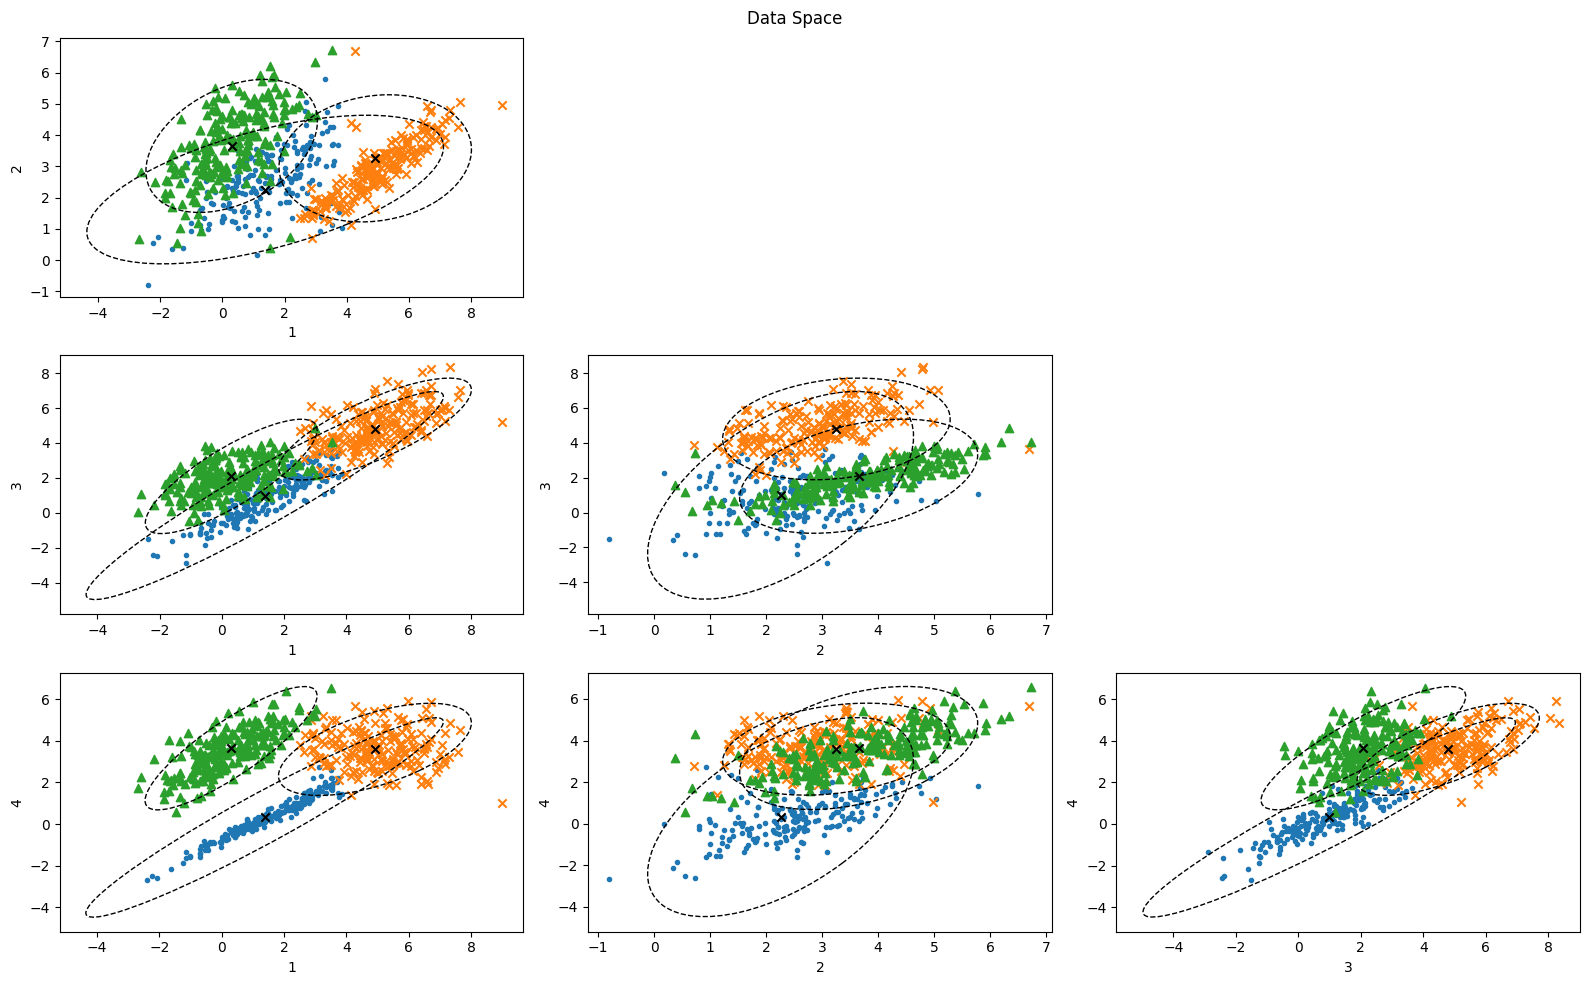

In [12]:
Z = model.transform(data)

clusters = model.predict(data)
responsibility = model.predict_proba(data)

model.plot_latent_space(Z=Z, clusters=clusters)
model.plot_data_space(Y=data, clusters=clusters)

## Model selection for 4D-Gaussian distributions

To select the best suited number of latent factors `n_factors` and number of
components `n_components` for the model, both the Bayesian Information Criterion
(BIC) and the Integrated Completed Likelihood (ICL) are implemented. The ICL is
equivalent to the BIC minus a penalty on the cluster confusion (i.e. the entropy
of the responsibility matrix $\tau$). It therefore suggests an equal or smaller
number of components than the BIC.


Training : 100%|██████████| 10/10 [00:01<00:00,  5.96epoch/s]


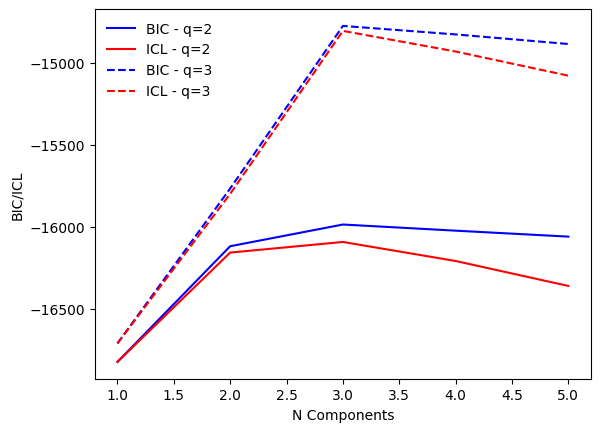

In [13]:
n_components = range(1, 6)

LS = {2: "-", 3: "--", 4: "-.", 5: ":"}

fig, ax = plt.subplots()

for q in [2, 3]:

    bic = []
    icl = []

    for g in n_components:

        model = MCFA(n_components=g, n_factors=q)

        model.fit(
            data,
            n_epochs=10,
            learning_rate=3e-4,
            frac_validation=0.0,
            batch_size=40,
        )

        model.transform(data)

        bic.append(model.bic(data))
        icl.append(model.icl(data))

    ax.plot(n_components, bic, label=f"BIC - q={q}", c="blue", ls=LS[q])
    ax.plot(n_components, icl, label=f"ICL - q={q}", c="red", ls=LS[q])

ax.set(xlabel="N Components", ylabel="BIC/ICL")
ax.legend(frameon=False)

## 4D-Gaussian distribution in 2D-latent space with missing data

This example uses the same data as above, except that 30% of all observed
values are randomly removed. The model is trained in two latent dimensions
(`n_factors=2`) with three components (`n_components=3`). Afterwards, the missing
data is imputed using the derived cluster properties and cluster associations (`mcfa.MCFA.impute()`). Data points with imputed features are drawn with 50% opacity below.


In [14]:
dropout = 0.3  # randomly remove 30% of values

data.ravel()[
    np.random.choice(data.size, int(data.size * dropout), replace=False)
] = np.nan

# Some points may have had all observations removed - we remove those
data = data[~np.isnan(data).all(axis=1)]

# This is what the data looks like now
print(data.shape)
print(data[:10])

(596, 4)
[[-0.49381814         nan         nan  3.24414074]
 [ 1.99070592  4.79217337         nan  4.63712455]
 [        nan  2.8705742          nan  2.58759712]
 [-1.34620226  4.49922382  2.44697649         nan]
 [-2.60450833  2.82908129  1.0780758   2.272895  ]
 [ 1.33969907  4.74212681  2.1455065          nan]
 [ 1.01191453  5.1757523          nan         nan]
 [ 1.54449188  3.67028803         nan  3.7330275 ]
 [        nan  5.30373356  3.38900263  4.80491075]
 [        nan  3.71567104  1.82640072  4.34496555]]


In [15]:
g = 3  # number of latent components
q = 2  # number of latent factors

# Instantiate model
model = MCFA(n_components=g, n_factors=q)

# Fit the model parameters using ML
model.fit(
    data,
    n_epochs=200,  # number of training epochs
    learning_rate=1e-4,  # learning rate of gradient descent algorithm
    frac_validation=0.15,  # fraction of data used as validation set during training
    batch_size=4,  # batch size during gradient descent training
);

Training : 100%|██████████| 200/200 [00:54<00:00,  3.64epoch/s]


The model training is done on the observed datapoints only. However, to visualize the data in the latent space using the linear projection along the latent factors, we have to impute the missing values in the input data. To impute the missing parts of a sample, we use the Gaussian component which the sample was assigned to and get the most probable value for the missing part given the observed part.

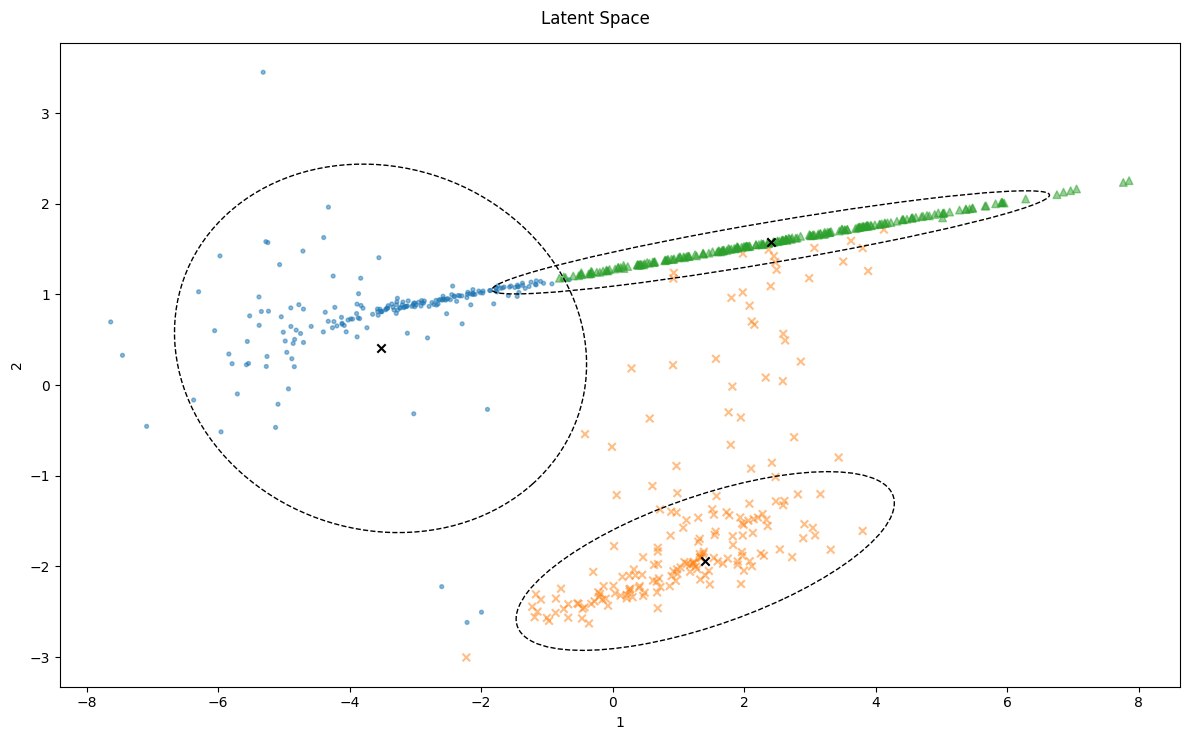

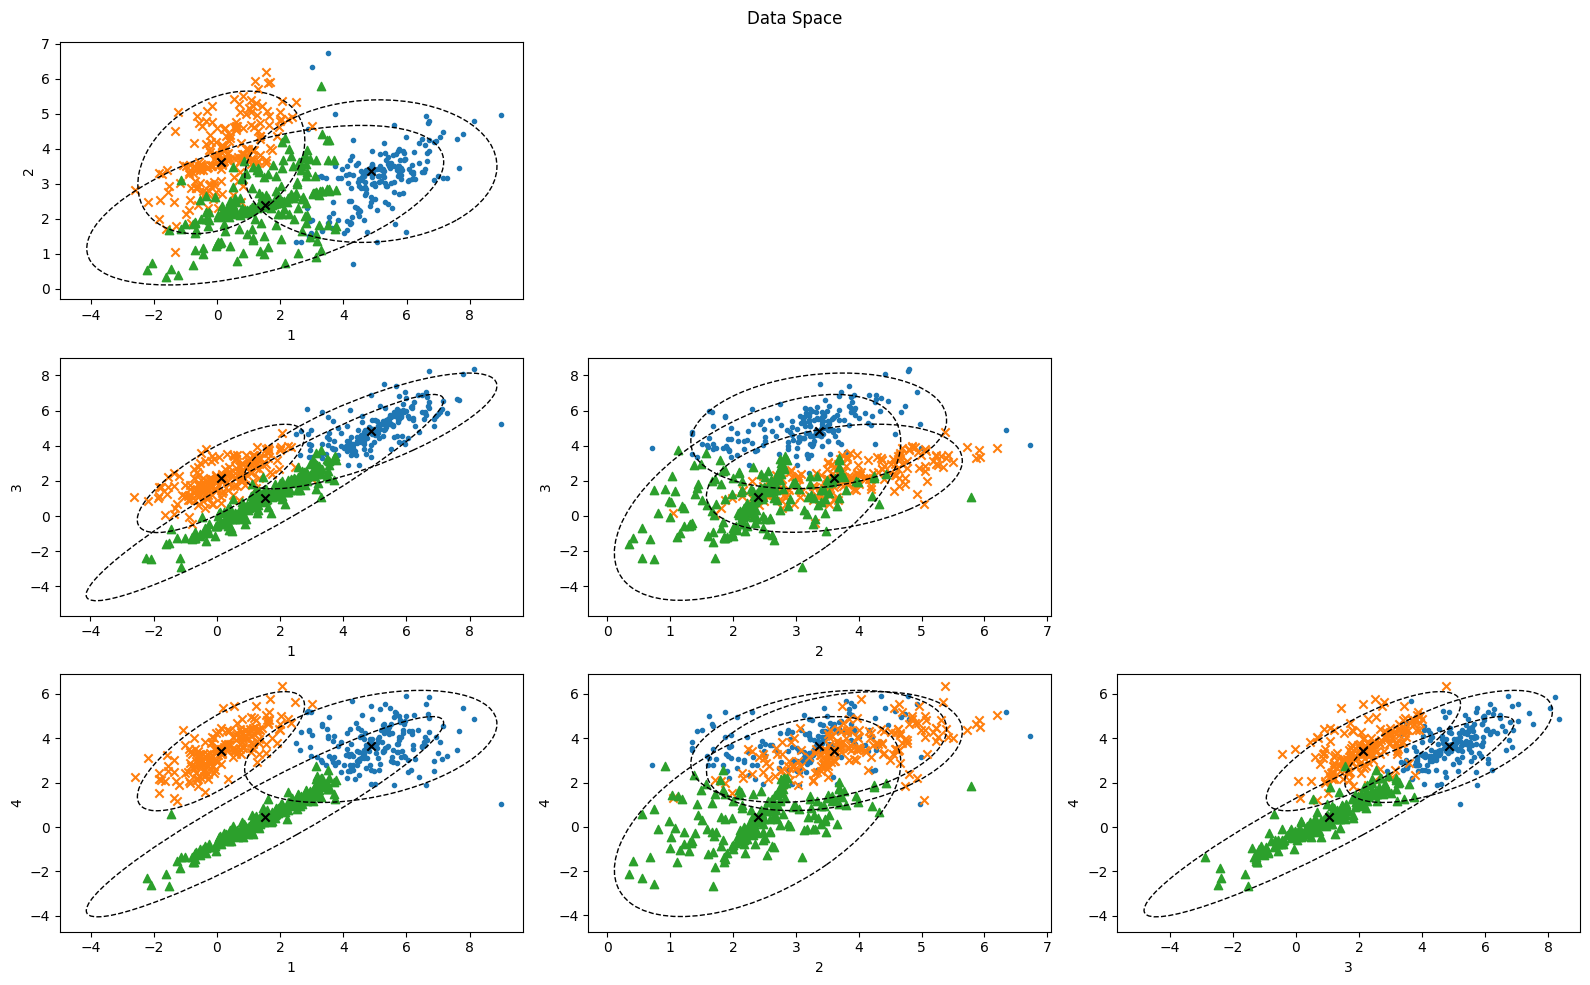

In [16]:
data_imputed = model.impute(data)

# Get the latent scores of all observations using the imputed data
Z = model.transform(data_imputed)

# Get the most likely clusters per sample for plotting
clusters = model.predict(data)
responsibility  = model.predict_proba(data) 

# Plot latent space and data space
model.plot_latent_space(Z=Z, clusters=clusters, mask_imputed=np.isfinite(data))
model.plot_data_space(Y=data_imputed, clusters=clusters)